In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import pickle
warnings.filterwarnings("ignore")

In [2]:
# In the first step we import the Dataset and get a first look over the data we have to deal with.
data = pd.read_csv(r"Churn_Modelling.csv")
data.head()
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [3]:
# After getting a first glimpse on the dataset we have to check if there are any NA in the dataset
data.isnull().values.any()

False

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

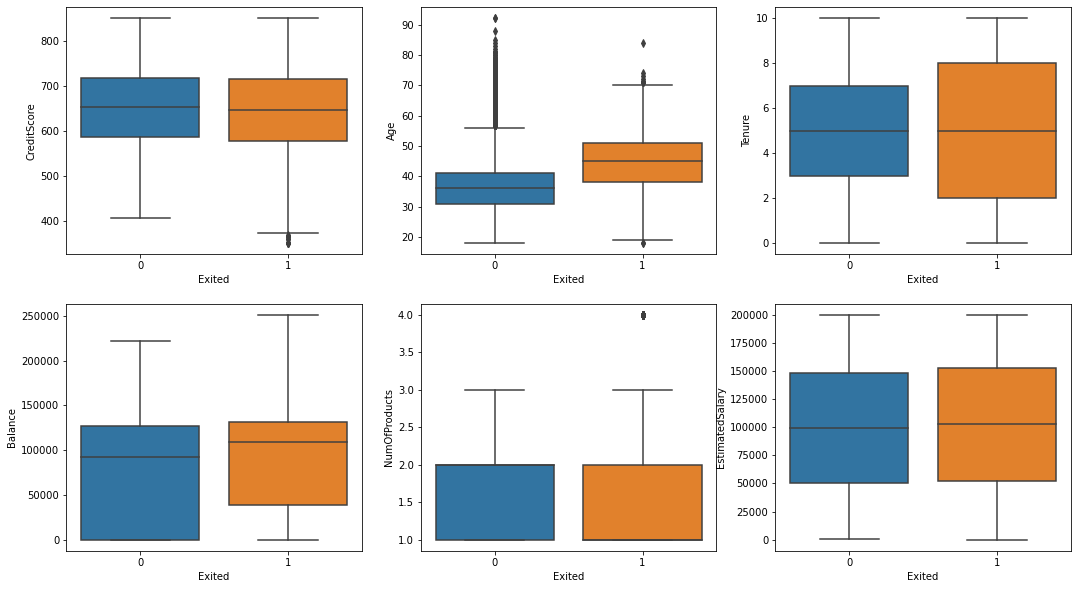

In [4]:
width = 3
height = 2

fig, axes = plt.subplots(height, width, figsize=(18, 10))
numeric = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]

sns.boxplot(ax=axes[0, 0], x = data["Exited"], y=data[numeric[0]])
sns.boxplot(ax=axes[0, 1], x = data["Exited"], y=data[numeric[1]])
sns.boxplot(ax=axes[0, 2], x = data["Exited"], y=data[numeric[2]])
sns.boxplot(ax=axes[1, 0], x = data["Exited"], y=data[numeric[3]])
sns.boxplot(ax=axes[1, 1], x = data["Exited"], y=data[numeric[4]])
sns.boxplot(ax=axes[1, 2], x = data["Exited"], y=data[numeric[5]])





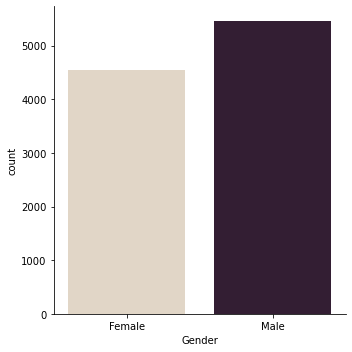

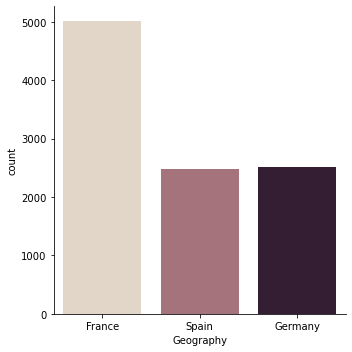

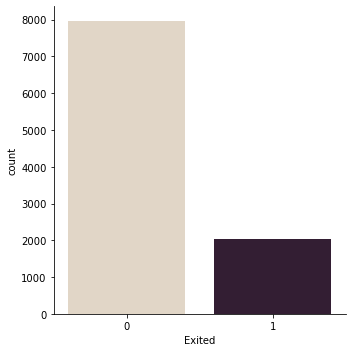

In [5]:
sns.catplot(ax=axes[0,0], x="Gender", kind="count", palette="ch:.25", data=data)
sns.catplot(ax=axes[0,1], x="Geography", kind="count", palette="ch:.25", data=data)
sns.catplot(ax=axes[0,1], x="Exited", kind="count", palette="ch:.25", data=data)



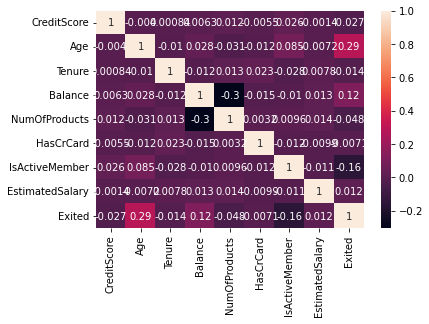

In [48]:
# Rather high correlations between Age and Exited and a negative correlation between Balance and number of products. 
# But nothing too high 
corr_ma = data.corr()
sns.heatmap(corr_ma, annot=True)
plt.show()

<AxesSubplot:xlabel='NumOfProducts', ylabel='Balance'>

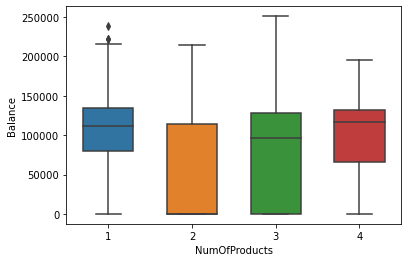

In [54]:
sns.boxplot(x = data["NumOfProducts"], y=data["Balance"], width=0.6)

<AxesSubplot:xlabel='NumOfProducts', ylabel='Balance'>

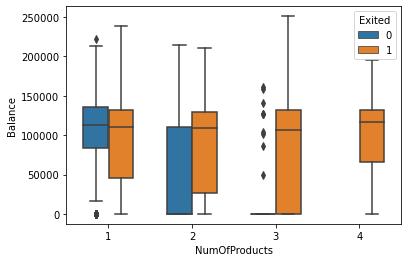

In [53]:
sns.boxplot(x = data["NumOfProducts"], y=data["Balance"], hue = data["Exited"], width=0.6)


In [47]:
# Now we can start preprocessing the dataset.
# The first step would be to remove all the unncessary columns in the datase. 
# Since The Rownumber, the name or the Id probably won't provide any usefull information, we can delete those 
# from our Dataset
del data["RowNumber"]
del data["Surname"]
del data["CustomerId"]

# It would also be possible to exclude “balance” because the range of the values is very big and
# it is not clear if the value of 0 is to interpret as a balance of 0 or as a missing value.
# But we will keep it for now.

In [7]:
# After the dataset is cleaned we can start with discriptive statistics.
# First we want to figure out how many people have churned
Churned = data["Exited"]
Ratio_churn = data["Exited"].sum()/data["Exited"].count()

# This shows that roughly 20% of the customers exited.
Ratio_churn#

0.2037

In [8]:
## For training, we want to perform a rebalancing of the labels in order to not overfit any label. 

churner = data[data["Exited"]==1]
non_churner = data[data["Exited"]==0]
non_churner_rb = non_churner.sample(int(len(non_churner)*0.4), replace = False)
data = pd.concat([churner,non_churner_rb], axis = 0).sample((len(churner)+len(non_churner_rb))).reset_index()
data = data.drop("index", axis =1)



In [9]:
Churned = data["Exited"]
Ratio_churn = data["Exited"].sum()/data["Exited"].count()

# After undersampling, the new ratio of churners is: 
Ratio_churn

0.3900804289544236

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]] = scaler.fit_transform(data[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]])

#import joblib
#scaler_filename = "scaler.save"
#joblib.dump(scaler, scaler_filename) 


In [11]:
# Generate dummies
cat_encoded = pd.get_dummies(data[["Geography", "Gender"]])
data = pd.concat([data,cat_encoded], axis = 1)
data = data.drop(["Geography", "Gender"], axis = 1)

In [12]:
Y = data["Exited"]
X = data.drop(["Exited"], axis = 1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=100)

In [17]:
!pip install XGBoost

     |████████████████████████████████| 173.6 MB 6.7 kB/s              


In [18]:
# import the models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
import time



In [120]:
start = time.time()

Randfor = RandomForestClassifier(random_state = 42)
Randfor.fit(X_train, y_train)
pred_forr = Randfor.predict(X_test)
print(accuracy_score(pred_forr, y_test))
print(f1_score(pred_forr,y_test))
confusion_matrix(pred_forr, y_test)

end = time.time()
print("{} seconds".format(round(end-start, 2)))

0.8046940486169321
0.7274853801169592
0.69 seconds


In [14]:
import time


start = time.time()

DT = DecisionTreeClassifier(random_state = 42)
DT.fit(X_train, y_train)
pred_DT = DT.predict(X_test)
print(accuracy_score(pred_DT, y_test))
print(f1_score(pred_DT,y_test))

end = time.time()
print("{} seconds".format(round(end-start,2)))

0.7128637059724349
0.6505125815470644
0.04 seconds


In [20]:
import time


start = time.time()

SVM = SVC(kernel = "rbf", random_state = 42)
SVM.fit(X_train, y_train)
pred_SVM = SVM.predict(X_test)
print(accuracy_score(pred_SVM, y_test))
print(f1_score(pred_SVM,y_test))

end = time.time()
print("{} seconds".format(round(end-start,2)))

0.7580398162327718
0.6409090909090909
1.41 seconds


In [21]:
start = time.time()


XGB = XGBClassifier(random_state = 42)
XGB.fit(X_train, y_train)
pred_xgb = XGB.predict(X_test)
print(accuracy_score(pred_xgb, y_test))
print(f1_score(pred_xgb, y_test))

end = time.time()
print("{} seconds".format(round(end-start,2)))

[08:17:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7901990811638591
0.735009671179884
0.83 seconds


In [ ]:
import numpy as np
import sys




class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        # Set sigmoid function as activation function
    
        def sigmoid(x):
            return 1/(1 + np.exp(-x))
        self.activation_function_hidden = sigmoid


    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)  # Implement the forward pass function below
            # Implement the backproagation function below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implemented forward pass
         
            Arguments
            ---------
            X: features batch

        '''
        # Forward pass
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) 
        hidden_outputs = self.activation_function_hidden(hidden_inputs) 

        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = self.activation_function_hidden(final_inputs) # signals from final output layer
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implemented backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        #### Implement the backward pass here ####
        ### Backward pass ###

        # TODO: Output error - Replace this value with your calculations.
        error = y - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # TODO: Calculate the hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, error)
                              
        # TODO: Backpropagated error terms - Replace these values with your calculations.
        output_error_term = error * 1.0
        
        hidden_error_term = hidden_error * hidden_outputs * (1-hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:, None]
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function_hidden(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = self.activation_function_hidden(final_inputs) # signals from final output layer 
        
        return final_outputs


#########################################################
# Set your hyperparameters here
##########################################################
iterations = 12000
learning_rate = 1.8
hidden_nodes = 16

output_nodes = 1

In [23]:
import numpy as np
import sys




class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        # Set sigmoid function as activation function
    
        def sigmoid(x):
            return 1/(1 + np.exp(-x))
        self.activation_function_hidden = sigmoid


    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)  # Implement the forward pass function below
            # Implement the backproagation function below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implemented forward pass
         
            Arguments
            ---------
            X: features batch

        '''
        # Forward pass
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) 
        hidden_outputs = self.activation_function_hidden(hidden_inputs) 

        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = self.activation_function_hidden(final_inputs) # signals from final output layer
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implemented backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        #### Implement the backward pass here ####
        ### Backward pass ###

        # TODO: Output error - Replace this value with your calculations.
        error = y - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # TODO: Calculate the hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, error)
                              
        # TODO: Backpropagated error terms - Replace these values with your calculations.
        output_error_term = error * 1.0
        
        hidden_error_term = hidden_error * hidden_outputs * (1-hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:, None]
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function_hidden(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = self.activation_function_hidden(final_inputs) # signals from final output layer 
        
        return final_outputs


#########################################################
# Set your hyperparameters here
##########################################################
iterations = 12000
learning_rate = 1.8
hidden_nodes = 16

output_nodes = 1

In [24]:
def bce(yhat: np.ndarray, y: np.ndarray) -> float:
    """Compute binary cross-entropy loss for a vector of predictions

    Arguments
    ----------
    yhat: array with len(yhat) predictions between [0, 1]
    y: array with len(y) labels where each is one of {0, 1}
    """
    return np.mean(-(y * np.log(yhat) + (1 - y) * np.log(1 - yhat)))


In [25]:
train_features, val_features, train_targets, val_targets = train_test_split(X_train, y_train, test_size = 0.25)

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}

start = time.time()
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    
    X, y = train_features.filter(items = batch, axis=0).values, train_targets.filter(items =batch,axis =0).values
                             
    network.train(X, y)
    
    # Printing out the training progress
 
    train_loss = bce((network.run(train_features).T)[0], (train_targets.values))
    val_loss = bce(network.run(val_features).T, val_targets.values)
    
    
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)


Progress: 100.0% ... Training loss: 0.408 ... Validation loss: 0.461

0.7917304747320061
0.7317554240631162
211.5 seconds


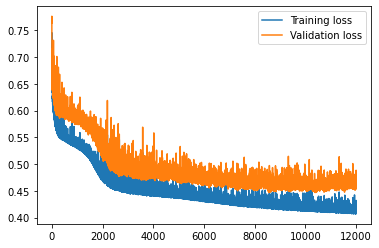

In [26]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

preds = np.round(network.run(X_test),0)
from sklearn.metrics import accuracy_score
print(accuracy_score(preds, y_test))
print(f1_score(preds,y_test))
confusion_matrix(preds, y_test)
    

end = time.time()
print("{} seconds".format(round(end-start,2)))

In [ ]:
Y = data["Exited"]
X = data.drop(["Exited"], axis = 1)
X_val = X[:450]
y_val = y[:450]
X = X[:-450]
y = Y[:-450]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
from copy import deepcopy


params = XGB.get_params()

param_grid = {'gamma': [0, 0.1,0.2],
              'learning_rate': [0.25, 0.300000012, 0.4],
              'max_depth': [5,6,7],
              'n_estimators': [80,100,120],
              'reg_alpha': [0,0.2,0.4],
              'reg_lambda': [0.2,0.5,1]}

In [117]:
clf = GridSearchCV(XGB, param_grid, cv = 2, verbose = 1, scoring='f1_micro')
from tqdm import tqdm

tqdm(clf.fit(X_train, y_train))

Fitting 2 folds for each of 729 candidates, totalling 1458 fits
[16:48:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'


0it [00:00, ?it/s]

In [118]:
best_params = clf.best_params_
GS_clf_best = XGBClassifier(**best_params)
GS_clf_best.fit(X_train, y_train)
preds = clf.predict(X_val)
f1_score(preds, y_val)

[17:00:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8176100628930818

In [140]:
# Safe the model
import pickle
filename = 'finalized_model2.sav'
pickle.dump(GS_clf_best, open(filename, 'wb'))#

In [119]:
best_params

{'gamma': 0,
 'learning_rate': 0.25,
 'max_depth': 5,
 'n_estimators': 80,
 'reg_alpha': 0.4,
 'reg_lambda': 1}

In [137]:
for i, value in enumerate(GS_clf_best.feature_importances_):
    print("{}: {}".format(X_train.columns[i], round(value, 2)))

CreditScore: 0.029999999329447746
Age: 0.15000000596046448
Tenure: 0.029999999329447746
Balance: 0.05999999865889549
NumOfProducts: 0.27000001072883606
HasCrCard: 0.03999999910593033
IsActiveMember: 0.1899999976158142
EstimatedSalary: 0.029999999329447746
Geography_France: 0.03999999910593033
Geography_Germany: 0.09000000357627869
Geography_Spain: 0.019999999552965164
Gender_Female: 0.05999999865889549
Gender_Male: 0.0


In [42]:
class churn_predictor():
    
    def __init__(self,customer_dataset, customer_id):
        self.customer_dataset = customer_dataset
        self.customer_id = customer_id

    def churn_thread_detection_single(self):
        ''' Perform preprocessing and churn probability calculation for a single customer based on the customerid.

                Arguments
                ---------
                customer_data: Whole Dataset
                customer_id : customer id

            '''


        extracted_ids = self.customer_dataset[["CustomerId", "Surname"]]
        customer_dataset = self.customer_dataset.drop(["RowNumber","Surname", "CustomerId"], axis = 1)
        scaler = joblib.load(open('scaler.save', 'rb'))
        customer_dataset[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]] = scaler.transform(customer_dataset[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]])
        cat_encoded = pd.get_dummies(customer_dataset[["Geography", "Gender"]])
        customer_dataset = pd.concat([customer_dataset,cat_encoded], axis = 1)
        customer_dataset = customer_dataset.drop(["Geography", "Gender"], axis = 1)
        clf = pickle.load(open('finalized_model2.sav', 'rb'))
        probabilities = clf.predict_proba(customer_dataset)
        customer_dataset["probabilities"] = probabilities[:, 1]

        customer_dataset = pd.concat([customer_dataset, extracted_ids], axis = 1)


        if customer_dataset[customer_dataset.CustomerId == self.customer_id]["probabilities"].values[0] > 0.8:
            statement = "Customer {} with Customer ID {} is highly threatened to churn. Please contact the customer immediately!".format(customer_dataset["Surname"].values[0], customer_dataset["CustomerId"].values[0])
        elif customer_dataset[customer_dataset.CustomerId == self.customer_id]["probabilities"].values[0]>0.5:
            statement = "Customer {} with Customer ID {} might be threatened to churn in the near future. Please contact the customer in the next weeks!".format(customer_dataset["Surname"].values[0], customer_dataset["CustomerId"].values[0])
        else:
            statement = "Customer {} with Customer ID {} is a loyal customer. Please think about loyalty benefits.".format(customer_dataset["Surname"].values[0], customer_dataset["CustomerId"].values[0])

        return print(statement)


    def churn_thread_detection_all(self):
        ''' Perform preprocessing and churn probability calculation for whole dataframe

                Arguments
                ---------
                customer_data: Whole Dataset

            '''


        extracted_ids = self.customer_dataset[["CustomerId", "Surname"]]
        customer_dataset = self.customer_dataset.drop(["RowNumber","Surname", "CustomerId"], axis = 1)
        scaler = joblib.load(open('scaler.save', 'rb'))
        customer_dataset[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]] = scaler.transform(customer_dataset[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]])
        cat_encoded = pd.get_dummies(customer_dataset[["Geography", "Gender"]])
        customer_dataset = pd.concat([customer_dataset,cat_encoded], axis = 1)
        customer_dataset = customer_dataset.drop(["Geography", "Gender"], axis = 1)
        clf = pickle.load(open('finalized_model2.sav', 'rb'))
        probabilities = clf.predict_proba(customer_dataset)
        customer_dataset["probabilities"] = probabilities[:, 1]

        customer_dataset = pd.concat([customer_dataset, extracted_ids], axis = 1)
        
        threatened_customers = customer_dataset[customer_dataset.probabilities >= 0.7]
        
        return threatened_customers
    
    
    

In [40]:
data_test = data.drop("Exited", axis = 1)
customer = churn_predictor(data_test, 15634602)

In [33]:
customer.churn_thread_detection_single()


Customer Hargrave with Customer ID 15634602 might be threatened to churn in the near future. Please contact the customer in the next weeks!


In [43]:
customer.churn_thread_detection_all()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,probabilities,CustomerId,Surname
2,0.304,0.324324,0.8,0.636357,0.666667,1,0,0.569835,1,0,0,1,0,0.997610,15619304,Onio
7,0.052,0.148649,0.4,0.458540,1.000000,1,0,0.596922,0,1,0,1,0,0.996296,15656148,Obinna
16,0.606,0.540541,0.1,0.528513,0.000000,1,0,0.025441,0,1,0,0,1,0.992431,15737452,Romeo
18,0.474,0.364865,0.6,0.000000,0.000000,0,0,0.793693,0,0,1,0,1,0.742805,15661507,Muldrow
30,0.482,0.283784,0.3,0.000000,0.666667,1,0,0.702578,0,0,1,1,0,0.951538,15589475,Azikiwe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,0.890,0.202703,0.9,0.416714,0.000000,1,1,0.604460,0,1,0,1,0,0.716502,15681026,Lucciano
9962,0.704,0.351351,0.9,0.000000,0.000000,0,0,0.296101,0,0,1,0,1,0.759983,15594612,Flynn
9975,0.520,0.432432,0.1,0.454196,0.333333,1,0,0.982980,0,1,0,0,1,0.774650,15666295,Smith
9982,0.610,0.378378,0.7,0.546617,0.000000,1,0,0.575911,0,1,0,1,0,0.880690,15768163,Griffin
